In [8]:
%%bash
pip install --upgrade tensorflow
pip install --upgrade tensorflow-gpu
pip install --upgrade keras

Requirement already up-to-date: tensorflow in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (2.1.0)
Requirement already up-to-date: tensorflow-gpu in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (2.1.0)
Requirement already up-to-date: keras in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (2.3.1)


In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [10]:
print(tf.__version__)

2.1.0


In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3920113279482399302, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2069376612470415979
 physical_device_desc: "device: XLA_CPU device"]

In [12]:
#tf.enable_eager_execution()
tf.executing_eagerly()

True

In [13]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [14]:
en_sentence = "i can 't tell who will arrive first ."
ja_sentence = "誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ja_sentence))

<start> i can 't tell who will arrive first . <end>
<start> 誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。 <end>


In [15]:
def create_dataset(path, num_examples):
    with open(path) as f:
        word_pairs = f.readlines()
    word_pairs = [preprocess_sentence(sentence) for sentence in word_pairs]

    return word_pairs[:num_examples]

In [16]:
path_train_en = 'small_parallel_enja/train.en'
path_train_ja = 'small_parallel_enja/train.ja'
en = create_dataset(path_train_en, None)
ja = create_dataset(path_train_ja, None)
print(en[-1])
print(ja[-1])

<start> he thought irritably . <end>
<start> 彼 は いらだ ち ながら 思 っ た 。 <end>


In [17]:
en[0:10]

["<start> i can 't tell who will arrive first . <end>",
 '<start> many animals have been destroyed by men . <end>',
 "<start> i 'm in the tennis club . <end>",
 '<start> emi looks happy . <end>',
 '<start> please bear this fact in mind . <end>',
 '<start> she takes care of my children . <end>',
 '<start> we want to be international . <end>',
 '<start> you ought not to break your promise . <end>',
 '<start> when you cross the street , watch out for cars . <end>',
 '<start> i have nothing to live for . <end>']

In [18]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [19]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [20]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    lang = create_dataset(path, num_examples)

    tensor, lang_tokenizer = tokenize(lang)

    return tensor, lang_tokenizer

In [21]:
# このサイズのデータセットで実験
num_examples = 30000
input_tensor, inp_lang = load_dataset(path_train_en, num_examples)
target_tensor, targ_lang = load_dataset(path_train_ja, num_examples)
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [22]:
max_length_targ

18

In [23]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [24]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [25]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
146 ----> two
155 ----> people
80 ----> were
784 ----> killed
12 ----> in
4 ----> the
522 ----> traffic
201 ----> accident
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
26 ----> その
591 ----> 交通
182 ----> 事故
11 ----> で
707 ----> ２人
13 ----> が
207 ----> 死
29 ----> ん
22 ----> だ
3 ----> 。
2 ----> <end>


In [26]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [27]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 18]))

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [29]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)



In [30]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [31]:
attention_layer = BahdanauAttention(10)


In [32]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [33]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)



In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [35]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [36]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                     ？    batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2325
Epoch 1 Batch 100 Loss 0.2644
Epoch 1 Batch 200 Loss 0.3066
Epoch 1 Batch 300 Loss 0.2801
Epoch 1 Loss 0.3257
Time taken for 1 epoch 100.6842188835144 sec

Epoch 2 Batch 0 Loss 0.2551
Epoch 2 Batch 100 Loss 0.2223
Epoch 2 Batch 200 Loss 0.2186
Epoch 2 Batch 300 Loss 0.2433
Epoch 2 Loss 0.2469
Time taken for 1 epoch 101.46011853218079 sec

Epoch 3 Batch 0 Loss 0.1901
Epoch 3 Batch 100 Loss 0.1684
Epoch 3 Batch 200 Loss 0.1634
Epoch 3 Batch 300 Loss 0.1972
Epoch 3 Loss 0.1873
Time taken for 1 epoch 101.20538759231567 sec

Epoch 4 Batch 0 Loss 0.1496
Epoch 4 Batch 100 Loss 0.1286
Epoch 4 Batch 200 Loss 0.1508
Epoch 4 Batch 300 Loss 0.1538
Epoch 4 Loss 0.1443
Time taken for 1 epoch 101.6439094543457 sec

Epoch 5 Batch 0 Loss 0.0898
Epoch 5 Batch 100 Loss 0.1221
Epoch 5 Batch 200 Loss 0.0895
Epoch 5 Batch 300 Loss 0.1335
Epoch 5 Loss 0.1144
Time taken for 1 epoch 101.27703833580017 sec

Epoch 6 Batch 0 Loss 0.1019
Epoch 6 Batch 100 Loss 0.0782
Epoch 6 Batch 200 L

In [37]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [38]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [39]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [40]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [44]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt-9'

grand truth: 彼 ら は つい に それ が 真実 だ と 認め た 。
Input: <start> they finally acknowledged it as true . <end>
Predicted translation: ついに 彼 は それ を 言 っ た 。 <end> 


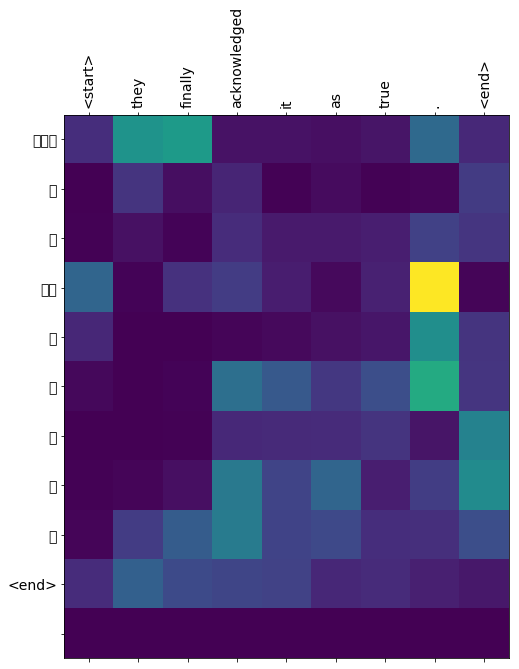

In [41]:
print('grand truth: 彼 ら は つい に それ が 真実 だ と 認め た 。')
translate('they finally acknowledged it as true .')

grand truth: 彼 は 水泳 が 得意 で は な かっ た 。
Input: <start> he didn 't care for swimming . <end>
Predicted translation: 彼 は どの くらい 上手 に も １０００ 酒 を 払 わ な かっ た 。 <end> 


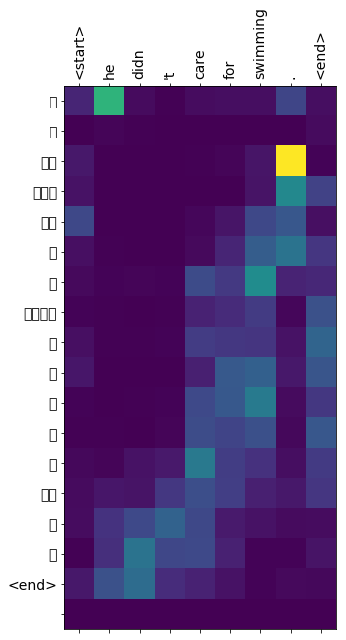

In [42]:
print('grand truth: 彼 は 水泳 が 得意 で は な かっ た 。')
translate("he didn 't care for swimming .")

grand truth: 彼 は お 姉 さん に 劣 ら ず 親切 だ 。
Input: <start> he is no less kind than his sister . <end>
Predicted translation: 彼 は 妹 より も 同じ くらい 親切 で は な い 。 <end> 


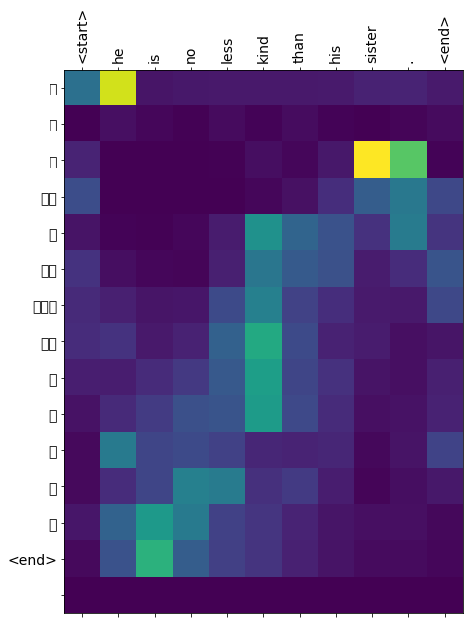

In [74]:
print('grand truth: 彼 は お 姉 さん に 劣 ら ず 親切 だ 。')
translate('he is no less kind than his sister .')

grand truth: １０ 時 前 に 戻 ら な けれ ば な ら な い 。
Input: <start> you must be back before ten . <end>
Predicted translation: 前 に １０ 時 に 戻 ら な けれ ば な ら な い 。 <end> 


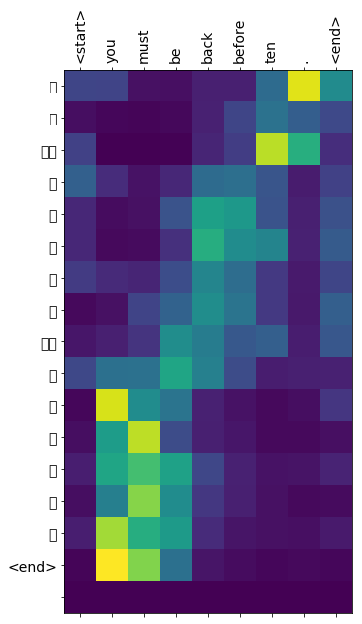

In [75]:
print('grand truth: １０ 時 前 に 戻 ら な けれ ば な ら な い 。')
translate('you must be back before ten .')